In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from dataloader import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import json
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()


num_cpus = len(os.sched_getaffinity(0))


def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_8'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        # print('filename:', filename)
        df = pd.read_csv(filename)
        
        if len(df) < 50: continue
        
        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]
        json_filename = filename.replace('.csv', '__args.json')
        assert os.path.exists(json_filename)
        
        adv_csv_json = json.load(open(json_filename, 'r'))
        
        df["filename"] = filename
        for key, val in adv_csv_json.items():
            df[key] = val
        df["i"] = df.index
        
        df = df.rename(columns={"model": "model_name"})

        mini_df = df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
        # print(adv_df)
    
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    for key in adv_csv_json.keys():
        if key not in baseline_df: baseline_df[key] = None
        
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)
    
    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str, max_num_samples: int):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm, max_num_samples=max_num_samples)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    batch_size = 256
    i = 0
    pbar = tqdm(total=len(adv_csv), leave=False, desc='Making predictions...')
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)

        i += batch_size
        pbar.update(batch_size)
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    
    
    model.document_model.cpu()
    model.document_embed.cpu()
    model.cpu()
    return adv_csv



In [3]:
n = 500

pmlm_tapas_lex_predictions = get_adv_predictions(model_key='model_3_5__epoch47', max_num_samples=n)
pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4', max_num_samples=n)
roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2', max_num_samples=n)
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3', max_num_samples=n)
# TODO: drop predictions if we predicted the same thing with same hparams just different values of n. Like
# if we have filenames with n=1000 and n=100. Just take the one with largest n.

running eval on model_3_5__epoch47 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__pmlm-a__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/2lslhb53_41/checkpoints/epoch=47-step=27360.ckpt
Initialized model with learning_rate = 7e-05 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 62
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_5__epoch47/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_5__epoch47/val.pkl
>> l

running eval on model_3_4 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__pmlm-a__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_default/1g8o1iw3_749/checkpoints/epoch=65-step=150281-idf_total.ckpt
Initialized model with learning_rate = 5e-05 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 62
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/val.pkl
>> loaded 72831 test embed

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 62
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 3072])


running eval on model_3_3 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/2cr1gp87_28/checkpoints/epoch=68-step=157113.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 62
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 3072])


In [18]:
new_model_name = {
    'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
    'model_3_5__epoch47': 'pmlm_tapas_lex',
}

preds_by_model_name = {
    # 'roberta_tapas__no_masking': None,
    'roberta_tapas': roberta_tapas_predictions,
    'roberta_roberta': roberta_roberta_predictions,
    'pmlm_tapas': pmlm_tapas_predictions,
    'pmlm_tapas_lex': pmlm_tapas_lex_predictions,
}

##############################################################################################################

out_df = pmlm_tapas_lex_predictions.rename(
    columns={
        'pred_topk_values': 'pmlm_tapas_lex__pred_topk_values', 
        'pred_topk_idxs': 'pmlm_tapas_lex__pred_topk_idxs'
    }
)
out_df['model_name'] = out_df['model_name'].apply(lambda s: new_model_name.get(s, s))

# Only take predictions from the first files outputted. Sometimes they change in-between
# so some dataframes have more than others.
shared_filenames = pmlm_tapas_lex_predictions['filename'].unique()

for model_name, model_df in preds_by_model_name.items():
    print(model_name)
    model_df['was_correct'] = (
        model_df['pred_topk_idxs'].map(lambda L: L[0]) == model_df['i']
    )
    model_df_smaller = model_df[model_df['filename'].map(lambda s: s in shared_filenames)].reset_index()
    out_df[f'{model_name}__was_correct'] = (
        # TODO: figure out why we need tolist() here.
        model_df_smaller['was_correct'].tolist()
    )
    print(f'{model_name}__was_correct', out_df[f'{model_name}__was_correct'].mean())
    out_df[f'{model_name}__topk_idxs'] = model_df_smaller['pred_topk_idxs']
    out_df[f'{model_name}__topk_values'] = model_df_smaller['pred_topk_values']
    
out_df['any_model__was_correct'] = (
    out_df['roberta_roberta__was_correct'] | 
    out_df['roberta_tapas__was_correct'] | 
    out_df['pmlm_tapas__was_correct'] | 
    out_df['pmlm_tapas_lex__was_correct']
)

out_df['perturbed_text'] = out_df['perturbed_text'].map(lambda s: s.replace('[MASK]', '<mask>'))
out_df['num_masks'] = out_df['perturbed_text'].map(lambda s: s.count('<mask>'))

out_df = out_df.drop(columns=['level_0', 'index', 'Unnamed: 0'], errors='ignore')
out_df.head()

roberta_tapas
roberta_tapas__was_correct 0.1532258064516129
roberta_roberta
roberta_roberta__was_correct 0.16451612903225807
pmlm_tapas
pmlm_tapas__was_correct 0.06088709677419355
pmlm_tapas_lex
pmlm_tapas_lex__was_correct 0.07741935483870968


,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,...,roberta_roberta__topk_idxs,roberta_roberta__topk_values,pmlm_tapas__was_correct,pmlm_tapas__topk_idxs,pmlm_tapas__topk_values,pmlm_tapas_lex__was_correct,pmlm_tapas_lex__topk_idxs,pmlm_tapas_lex__topk_values,any_model__was_correct,num_masks
0,Lenny randle,"leonard shenoff randle ( born february 12 , 19...",Mike lowell,"<mask> <mask> <mask> ( born <mask> <mask> , <m...",-15.695010,0.200135,0.0,62119.0,0.0,682.0,...,"[394614, 370397, 681800, 168848, 120367, 66171...","[0.0023584619630128145, 0.0023358629550784826,...",False,"[213899, 62119, 161970, 642984, 450117, 361099...","[0.005146904848515987, 0.004467497114092112, 0...",False,"[92454, 342345, 574481, 226248, 232407, 403485...","[0.009857593104243279, 0.0077886031940579414, ...",False,25
1,Philippe adnot,philippe adnot ( born 25 august 1945 in rhèges...,René revol,<mask> <mask> ( born <mask> <mask> <mask> in r...,-14.942733,1.879272,1.0,59276.0,1.0,1140.0,...,"[1, 598910, 255263, 720544, 305245, 484220, 55...","[0.05593491345643997, 0.04826468601822853, 0.0...",False,"[59276, 54198, 667661, 135213, 720544, 142867,...","[0.12335715442895889, 0.07929302752017975, 0.0...",False,"[467415, 168807, 627677, 177199, 266604, 28255...","[0.16440579295158386, 0.13092854619026184, 0.0...",True,17
2,Miroslav popov,miroslav popov ( born 14 june 1995 in dvůr krá...,Daniel ellensohn,<mask> <mask> ( born <mask> <mask> <mask> in <...,-17.340431,0.322910,2.0,135093.0,2.0,718.0,...,"[413790, 406179, 649674, 251468, 666200, 36481...","[0.00868439394980669, 0.006869043223559856, 0....",False,"[411254, 421828, 173826, 316114, 135093, 21736...","[0.022465845569968224, 0.019381940364837646, 0...",False,"[475310, 326260, 443220, 118152, 526488, 62272...","[0.01258728839457035, 0.012537403032183647, 0....",False,24
7,Giuliana zevallos,"giuliana zevallos roncagliolo ( born in lima ,...",Marianela salazar,"<mask> <mask> <mask> ( born in <mask> , <mask>...",-16.482500,0.172346,7.0,114702.0,7.0,1476.0,...,"[654676, 240110, 408599, 182788, 644962, 15082...","[0.11308088898658752, 0.06419963389635086, 0.0...",False,"[181554, 604486, 407769, 274404, 55060, 538732...","[0.09008079767227173, 0.07307087630033493, 0.0...",False,"[589965, 515523, 18429, 231537, 332960, 15, 38...","[0.34307268261909485, 0.13987168669700623, 0.0...",False,49
10,Dan besse,daniel vaughn ( dan ) besse ( born december 28...,Harry van bommel,<mask> <mask> ( <mask> ) <mask> ( born <mask> ...,-15.718194,0.384187,10.0,51388.0,10.0,1987.0,...,"[335700, 466667, 586860, 398071, 405823, 18960...","[0.06262224167585373, 0.04663459211587906, 0.0...",False,"[636693, 702557, 257095, 161955, 484223, 42159...","[0.04286709800362587, 0.019949639216065407, 0....",False,"[518619, 204925, 183745, 680453, 297271, 21538...","[0.09810711443424225, 0.030670901760458946, 0....",False,36


In [19]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white")

In [25]:
df_grouped = out_df.groupby("filename").mean().reset_index()

df_grouped["percent_masks"] = df_grouped["num_masks"] / df_grouped["num_words"]
df_grouped["percent_not_masks"] = 1.0 - df_grouped["percent_masks"]

print("% masks:", df_grouped["percent_masks"].mean())


def name_by_filename(filename: str) -> str:
    if filename in ['document', 'lexical', 'named_entity']:
        return filename
    elif 'nomodel' in filename:
        return 'IDF'
    elif 'k_None' in filename:
        return 'eps'
    elif '5__k' in filename:
        return 'k'
    else:
        return '??'

df_grouped["filename_short"] = df_grouped.apply(lambda row: name_by_filename(row['filename']), axis=1)
# df_grouped["filename_short"] = df_grouped["filename"].map(lambda s: s[s.rindex('/')+1:s.rindex('.csv')] if '.csv' in s else s) # TODO renamee
# df_grouped["model_name__k"] = df_grouped["model_name"] + df_grouped["k"].map(lambda k: f'__{k}')

# https://matplotlib.org/stable/api/markers_api.html
marker_by_model_name = {
    "lexical": "s", #"X",
    "named_entity": "s", # "X",
    "document": "s"
}
df_grouped["marker"] = df_grouped.apply(lambda row: marker_by_model_name.get(row["filename_short"], "o"), axis=1)

num_filenames = len(df_grouped["filename_short"].unique())
color_by_model_name = dict(
    zip(df_grouped["filename_short"].unique(), sns.color_palette("hls", num_filenames))
)
df_grouped["color"] = df_grouped["filename_short"].apply(color_by_model_name.get)

% masks: 0.29525368440197886


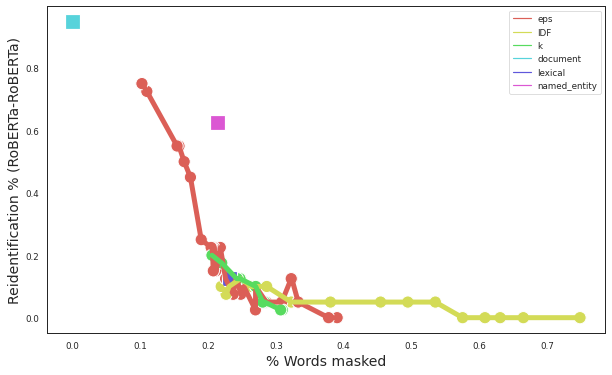

In [26]:
import matplotlib.pyplot as plt

def make_reid_plot(reid_model_name: str, x_column: str, xlabel: str, ylabel: str, marker_size: int = 150, set_lim=True):
    plt.figure(figsize=(10,6))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    group_key = "filename_short"
    
    # df_grouped_filtered = df_grouped
    df_grouped_filtered = df_grouped[
        df_grouped[group_key].apply(lambda row_model_name: (reid_model_name not in row_model_name))
    ]
    # print(df_grouped_filtered)
    y_column = f"{reid_model_name}__was_correct"
    
    g1 = sns.lineplot(
        data=df_grouped_filtered,
        x=x_column,
        y=y_column,
        hue=group_key,
        palette=color_by_model_name,
        linewidth=5,
        legend=True
    )
    # g1.set_xscale('log')
    g1.legend(loc='upper right')
    if set_lim: g1.set(xlim=(.18,.8), ylim=(-0.05, 0.45))
    for marker_type in df_grouped["marker"].unique():
        df_grouped_marker = df_grouped_filtered[
            df_grouped_filtered["marker"] == marker_type
        ]
        g2 = sns.scatterplot(
            data=df_grouped_marker,
            x=x_column,
            y=y_column,
            hue=group_key,
            palette=color_by_model_name,
            s=(marker_size if marker_type == 'o' else marker_size*1.5),
            marker=marker_type,
            legend=False
        )
        # g2.set_xscale('log')
    if set_lim: g2.set(xlim=(.18,.8), ylim=(-0.05, 0.45))


make_reid_plot(reid_model_name="roberta_roberta", x_column="percent_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="% Words masked", set_lim=False)

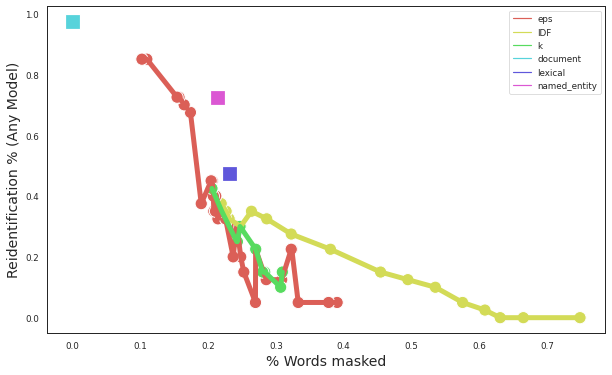

In [28]:
make_reid_plot(reid_model_name="any_model", x_column="percent_masks", ylabel="Reidentification % (Any Model)", xlabel="% Words masked", set_lim=False)

In [ ]:
make_reid_plot(reid_model_name="roberta_roberta", x_column="num_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="Num words masked", set_lim=False)

In [ ]:
((out_df["model_name"] == "pmlm_tapas") & (out_df["k"] == 1) & (out_df["p"] == 0.2)).count()

In [ ]:
df_grouped.iloc[4]

In [ ]:
df_grouped.sort_values(by='roberta_roberta__was_correct')

In [ ]:
df